# Download Airbus Dataset

In [1]:
!pip install -q kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /home/jupyter/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c airbus-ship-detection

100%|█████████████████████████████████████▉| 28.6G/28.6G [06:22<00:00, 93.7MB/s]
100%|██████████████████████████████████████| 28.6G/28.6G [06:22<00:00, 80.2MB/s]


In [4]:
!unzip -q airbus-ship-detection.zip -d airbus-dataset/

# Preliminary Analysis

In [66]:
import random 
import imageio

import pandas as pd
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt

In [3]:
# RLE code from: 
# https://www.kaggle.com/inversion/run-length-decoding-quick-start

masks = pd.read_csv('airbus-dataset/train_ship_segmentations_v2.csv')
masks.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [4]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [11]:
id_list = set(masks.loc[masks['EncodedPixels'].apply(lambda x: isinstance(x, str))]['ImageId'].tolist())

In [13]:
list(id_list)[:10]

['27893f5d5.jpg',
 'a851cd532.jpg',
 '8de34429f.jpg',
 '6b7daf48c.jpg',
 'abe94c389.jpg',
 '4c81f8c45.jpg',
 'd4ee7a7aa.jpg',
 'e190a8b43.jpg',
 'bbfada0b9.jpg',
 '751331052.jpg']

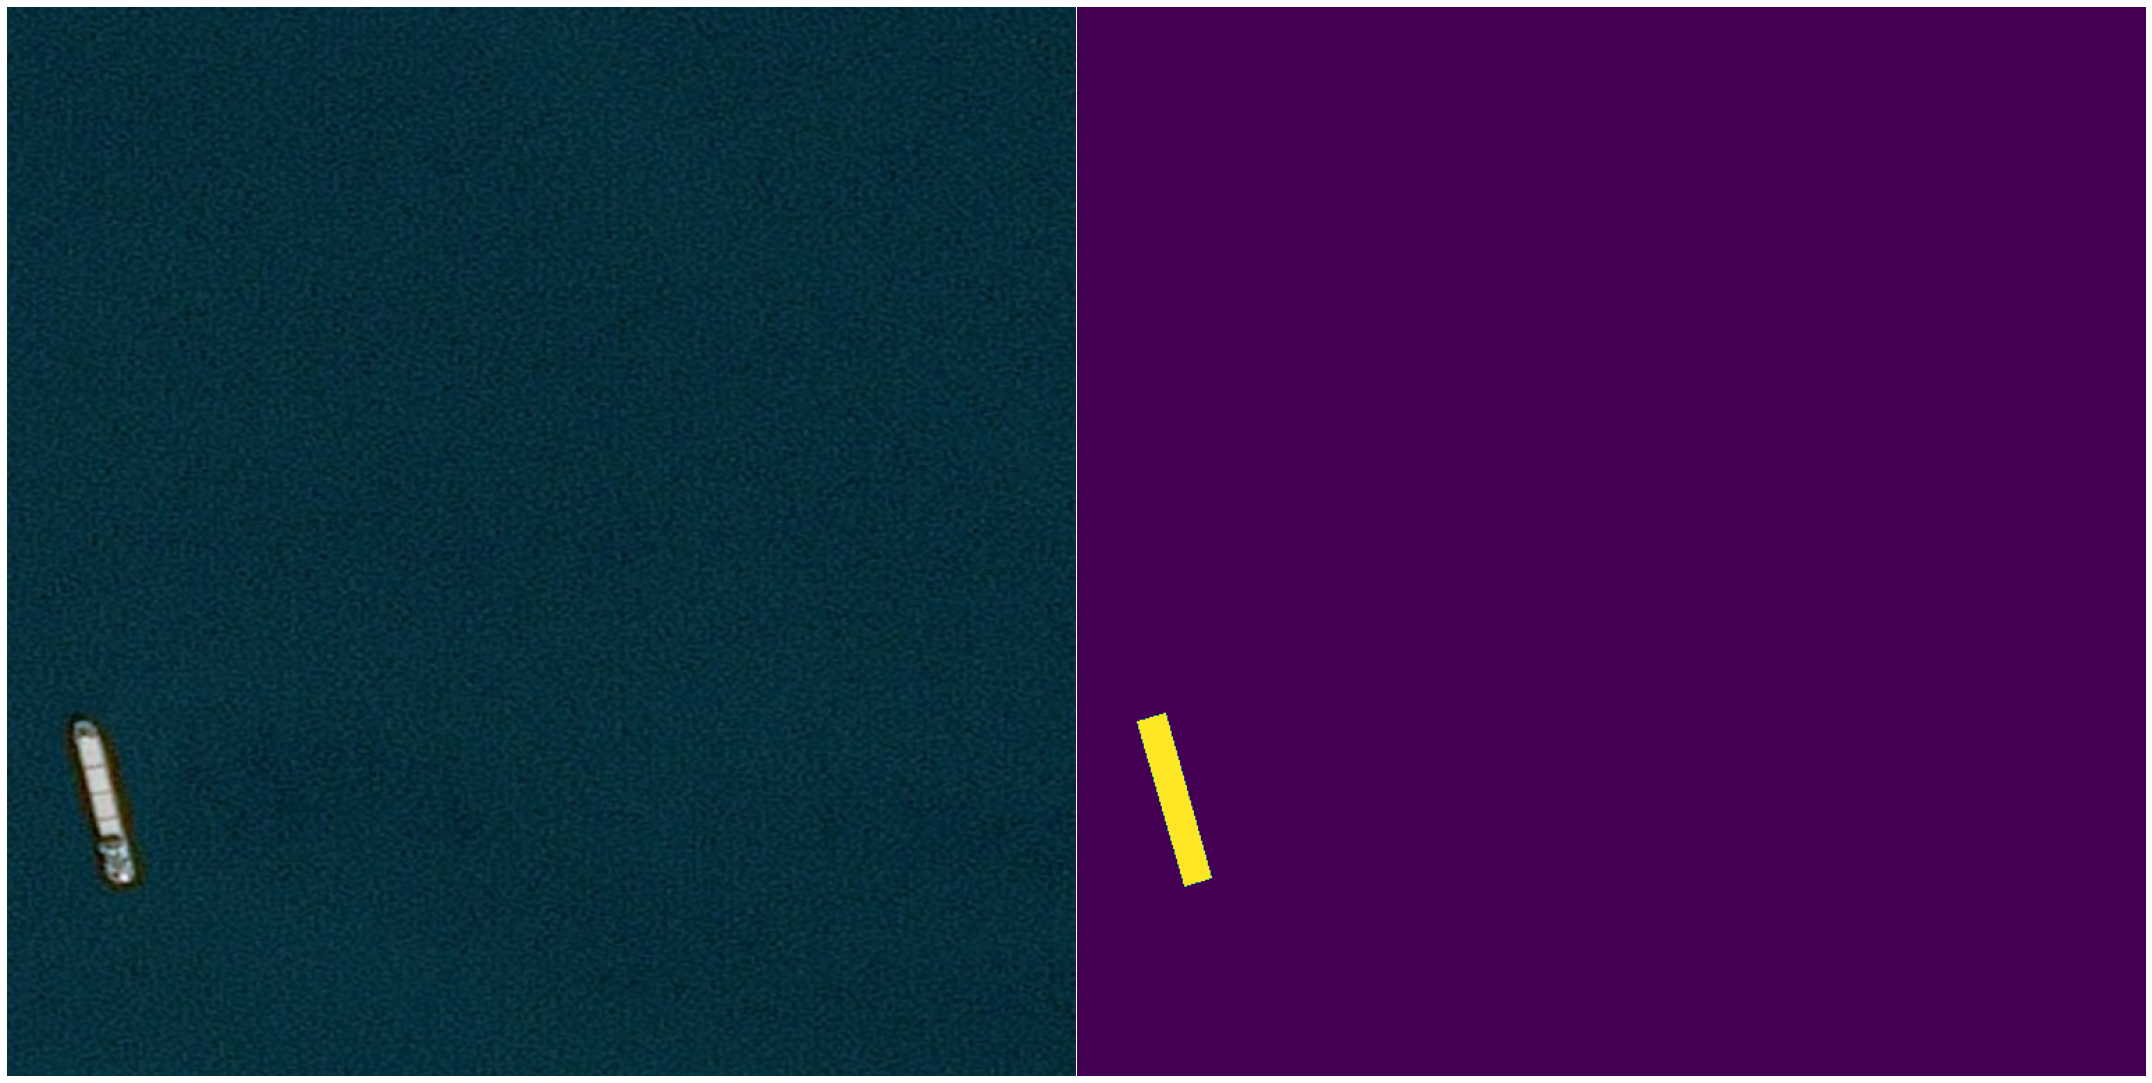

<Figure size 432x288 with 0 Axes>

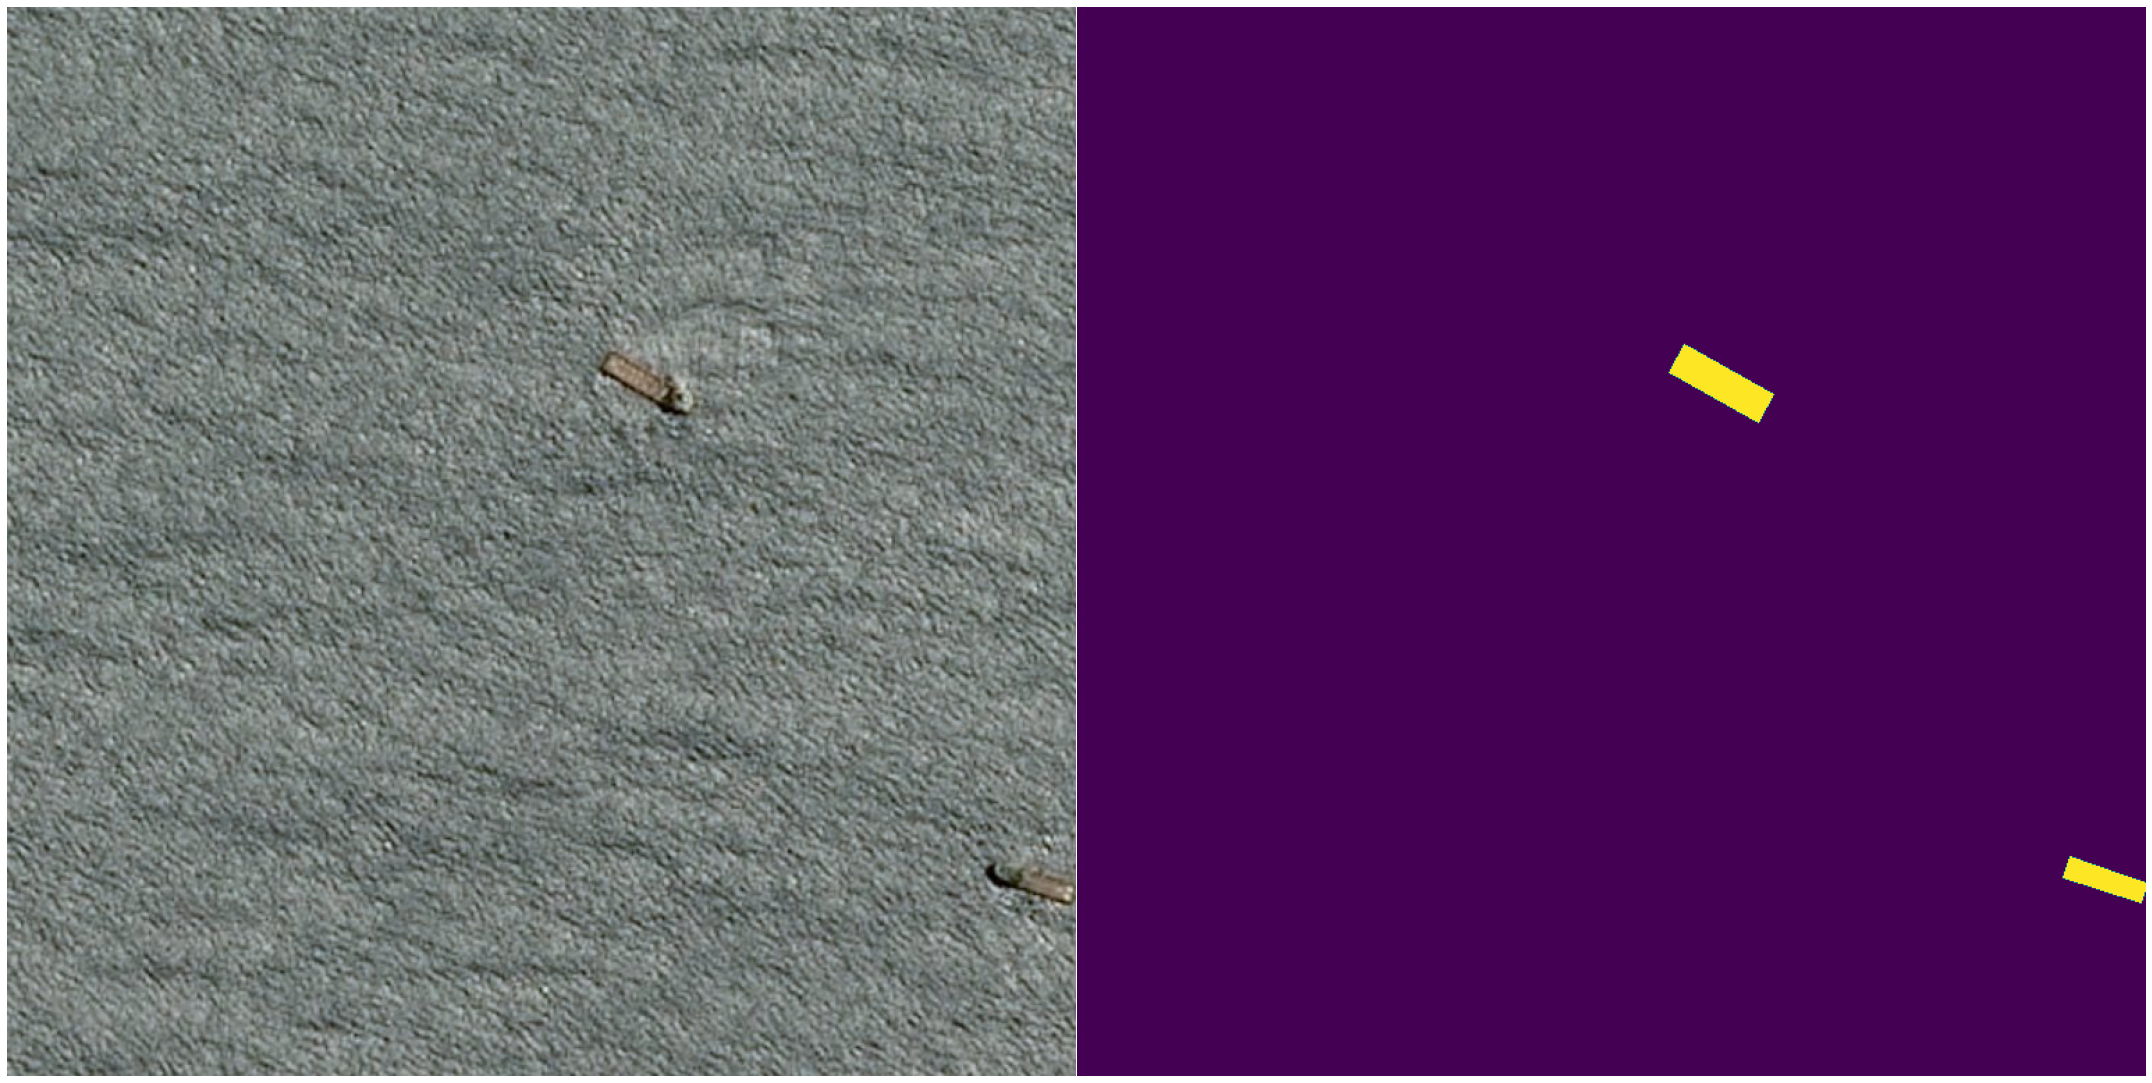

<Figure size 432x288 with 0 Axes>

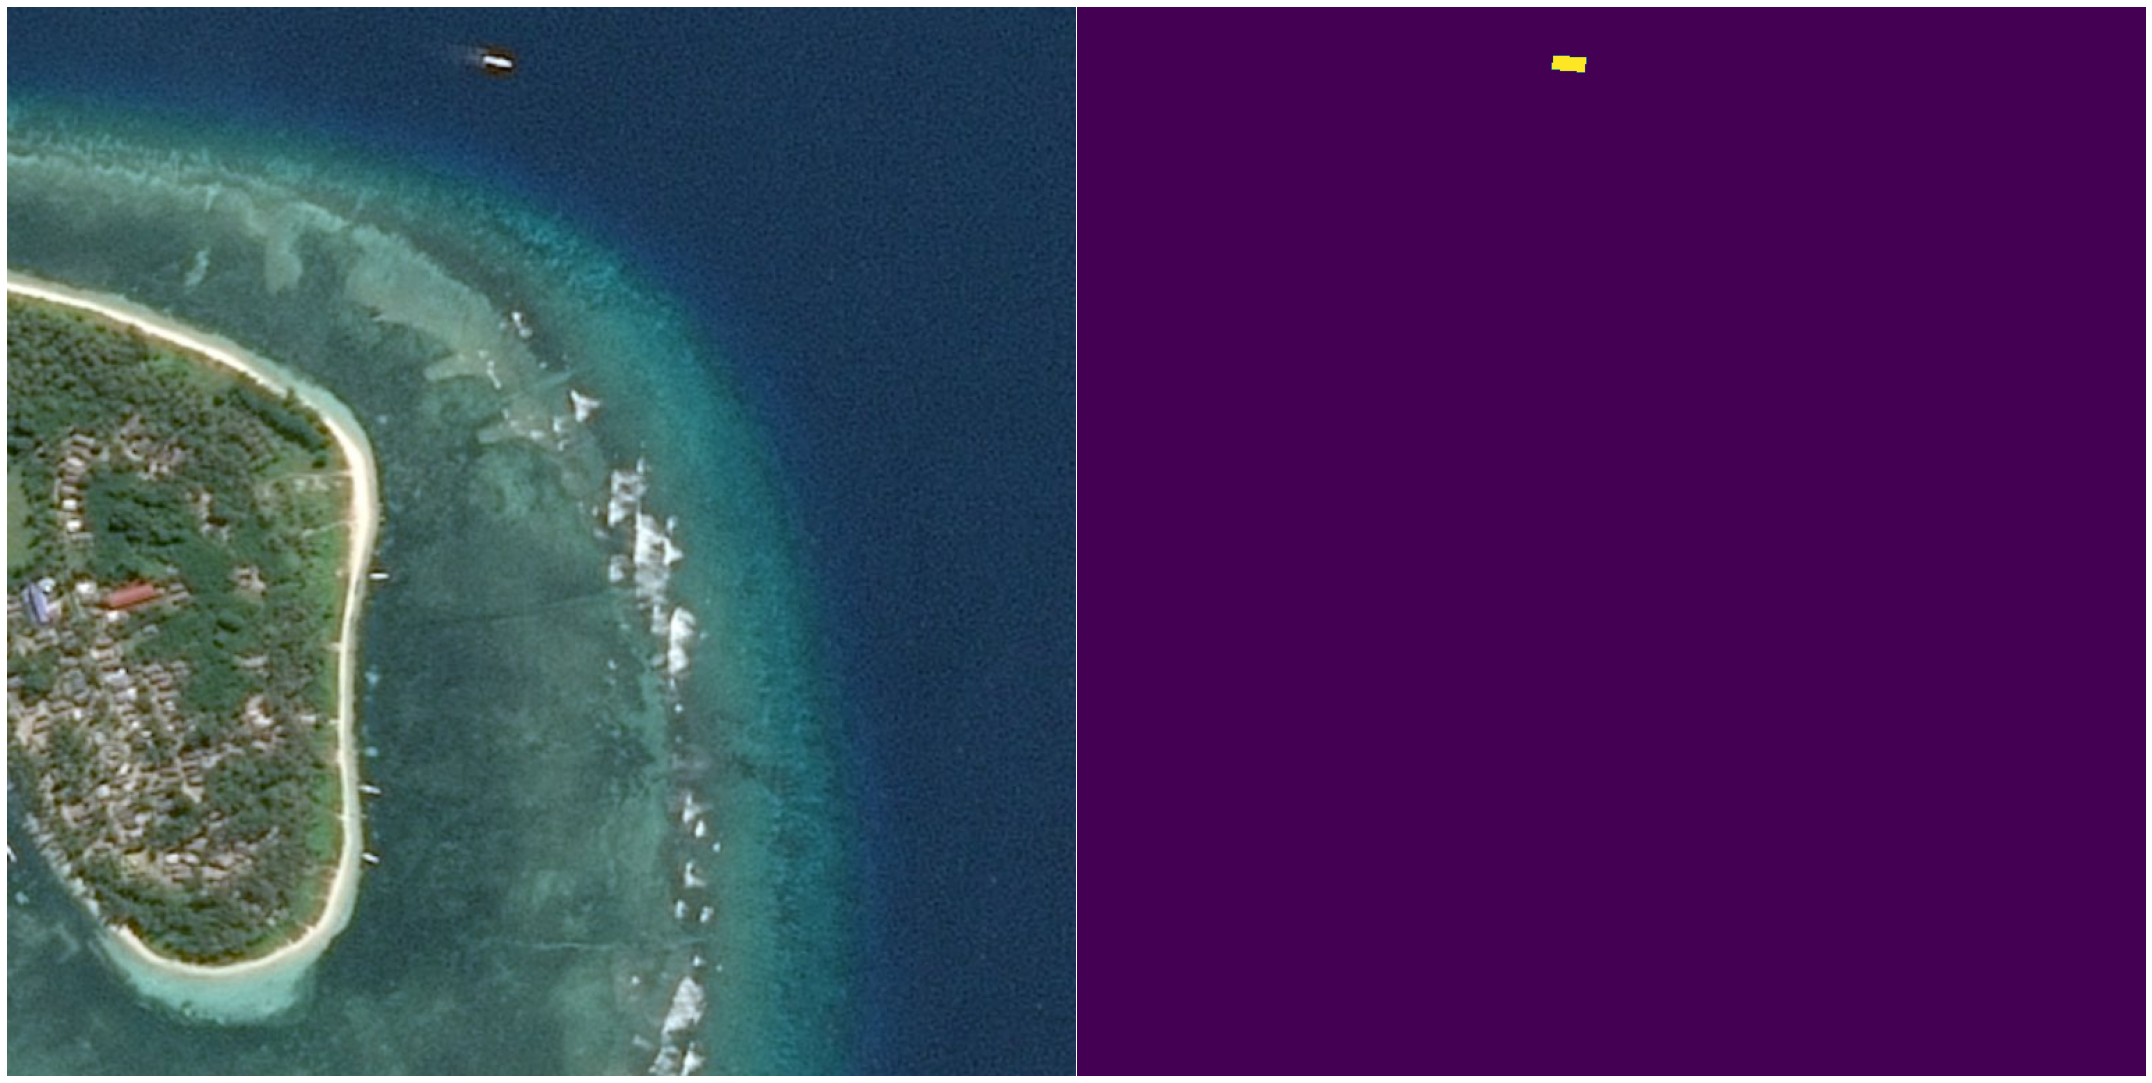

<Figure size 432x288 with 0 Axes>

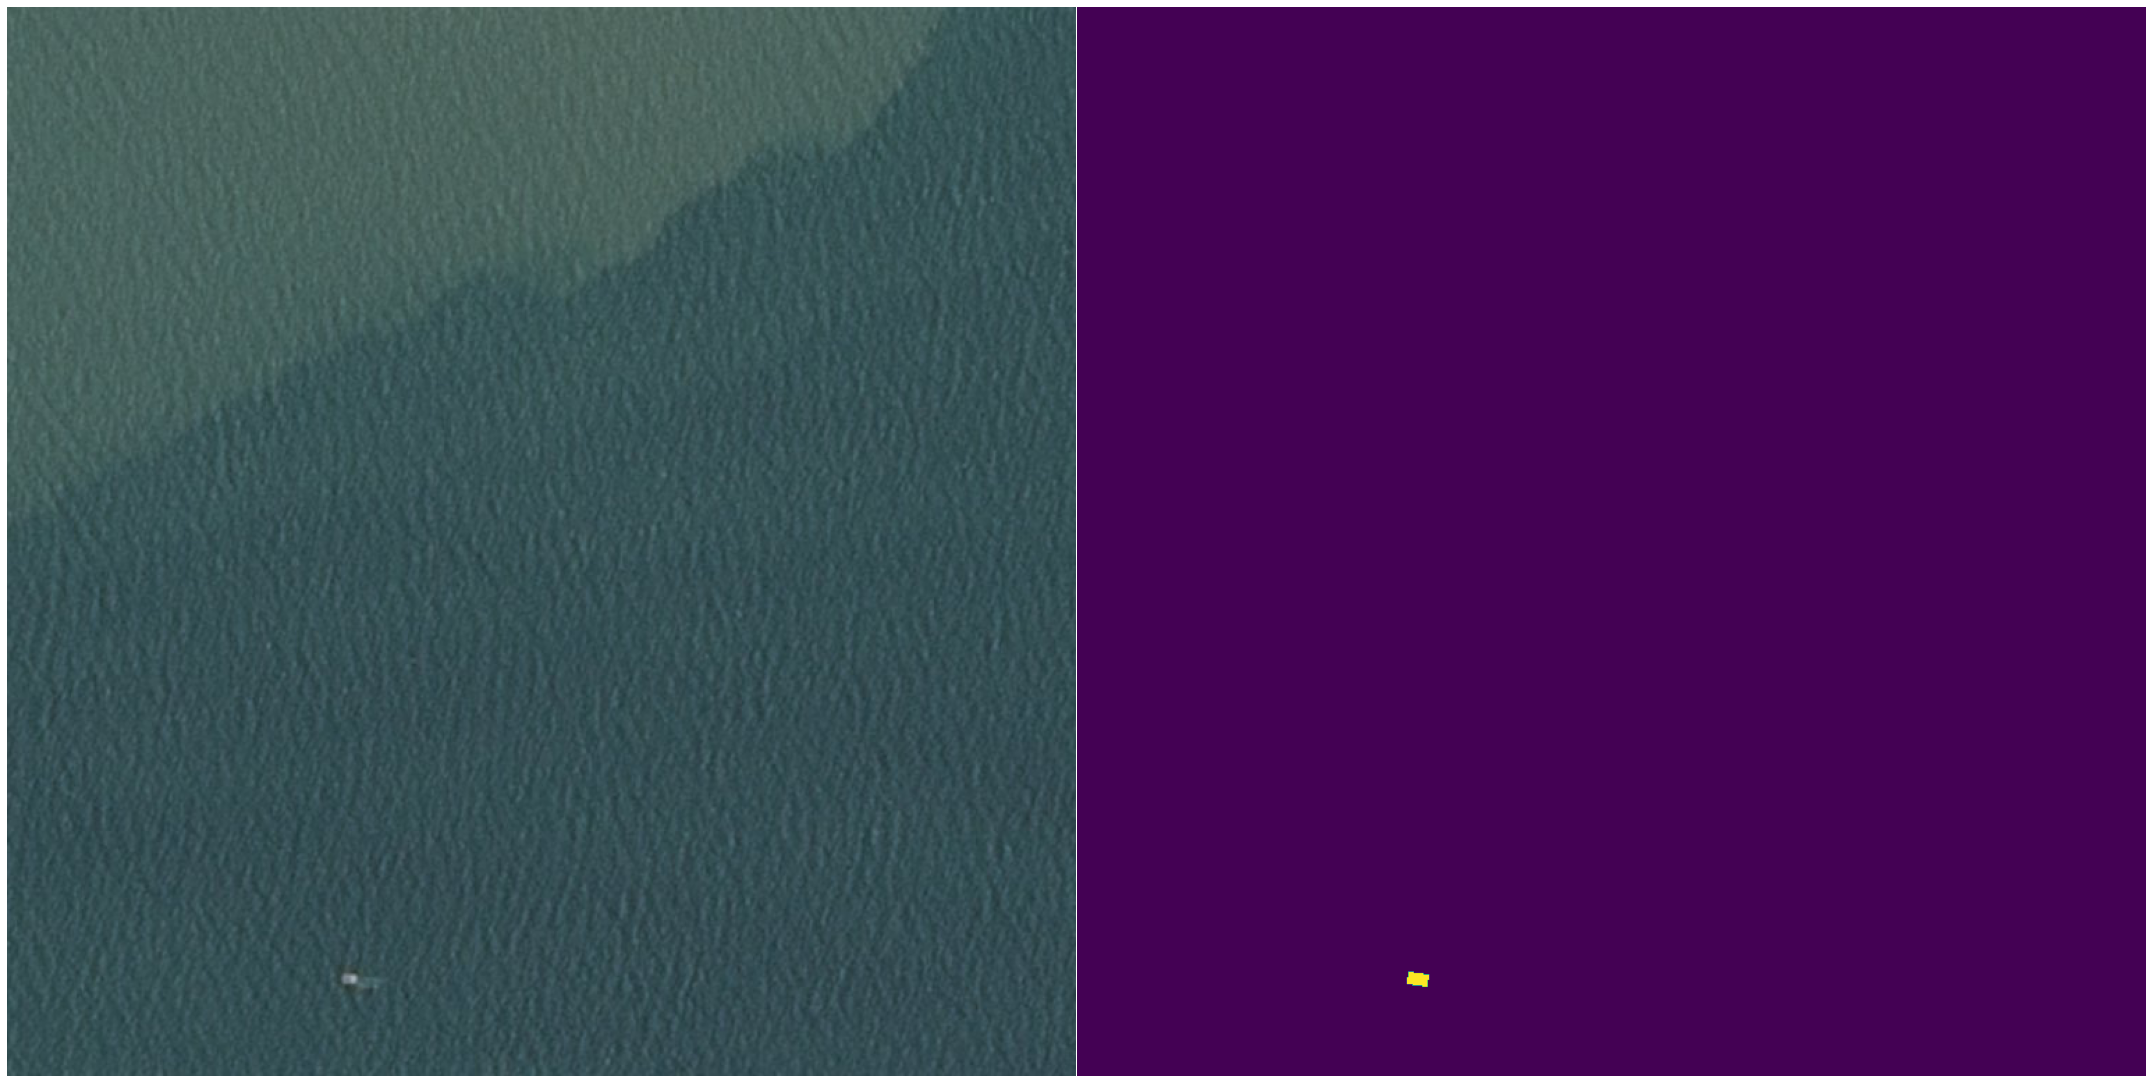

<Figure size 432x288 with 0 Axes>

In [ ]:
# Randomly choose ItemIds from the list for analysis
random_ids = random.sample(id_list, 25)
for ImageId in random_ids:
    img = imread('airbus-dataset/train_v2/' + ImageId)
    img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()


    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768))
    for mask in img_masks:
        all_masks += rle_decode(mask)

    #first_mask = np.zeros((768,768))
    #first_mask += rle_decode(img_masks[0])

    fig, axarr = plt.subplots(1, 2, figsize=(30, 80))
    axarr[0].axis('off')
    axarr[1].axis('off')
    #axarr[2].axis('off')
    #axarr[3].axis('off')
    axarr[0].imshow(img)
    axarr[1].imshow(all_masks)
    #axarr[2].imshow(img)
    #axarr[2].imshow(all_masks, alpha=0.4)
    #axarr[3].imshow(first_mask)
    plt.tight_layout(h_pad=0.1, w_pad=0.1)
    plt.show()
    
    savepath = r'random_samples/' + ImageId
    plt.savefig(savepath, bbox_inches='tight')

# Augment Data

In [ ]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction


# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def get_box_size(rle):
    if type(rle) is not str:
        return float('inf')
    s = rle.split()
    length = sum([int(x) for x in s[1:][::2]])
    return length
    
    
def filter_ids(masks, max_thresh=300):
    # Remove duplicates using set
    id_set_1 = set(masks.loc[masks['EncodedPixels'].apply(
        lambda x: get_box_size(x) <= max_thresh
        )]['ImageId'].tolist())
    id_set_2 = set(masks.loc[masks['EncodedPixels'].apply(
        lambda x: isinstance(x, str)
        )]['ImageId'].tolist())
    
    return list(id_set_1.intersection(id_set_2))


def downsample_img(img):
    return img[::2, ::2, :]


def downsample_mask(mask):
    return mask[::2, ::2]


def downsample_masks(image_id, masks):
    id_masks = masks.loc[masks['ImageId'] == image_id]['EncodedPixels']
    ds_masks = id_masks.apply(lambda x: downsample_mask(rle_decode(x))).tolist()
    return ds_masks
    
    
def augment_imgs(masks):
    print('Original number of training samples:', masks.shape[0])
    print('---------------------------')
    id_list = filter_ids(masks)
    print('Number of filtered training samples: ', len(id_list))
    print('---------------------------')
    print('Processing filtered samples...')
    for idx, image_id in enumerate(id_list):
        ds_masks = downsample_masks(image_id, masks)
        img = imread('airbus-dataset/train_v2/' + image_id)
        ds_img = downsample_img(img)
        
        # Create new id for downsampled image
        new_id = image_id[:-4] + '_ds' + image_id[-4:]
        
        # Save downsampled image to training directory
        imageio.imwrite('testybois/train_v2/' + new_id, ds_img)
        
        # Add new id and rle encoding to masks dataframe
        for mask in ds_masks:
            new_row = pd.DataFrame([[new_id, rle_encode(mask)]], columns=masks.columns)
            pd.concat([masks, new_row])
        if idx % 999 == 0 and idx > 0:
            print('Processed ', idx + 1, ' images...')
    print('Done.')
    return masks

Original number of training samples: 231723
---------------------------
Number of filtered training samples:  20997
---------------------------
Processing filtered samples...
(384, 384)


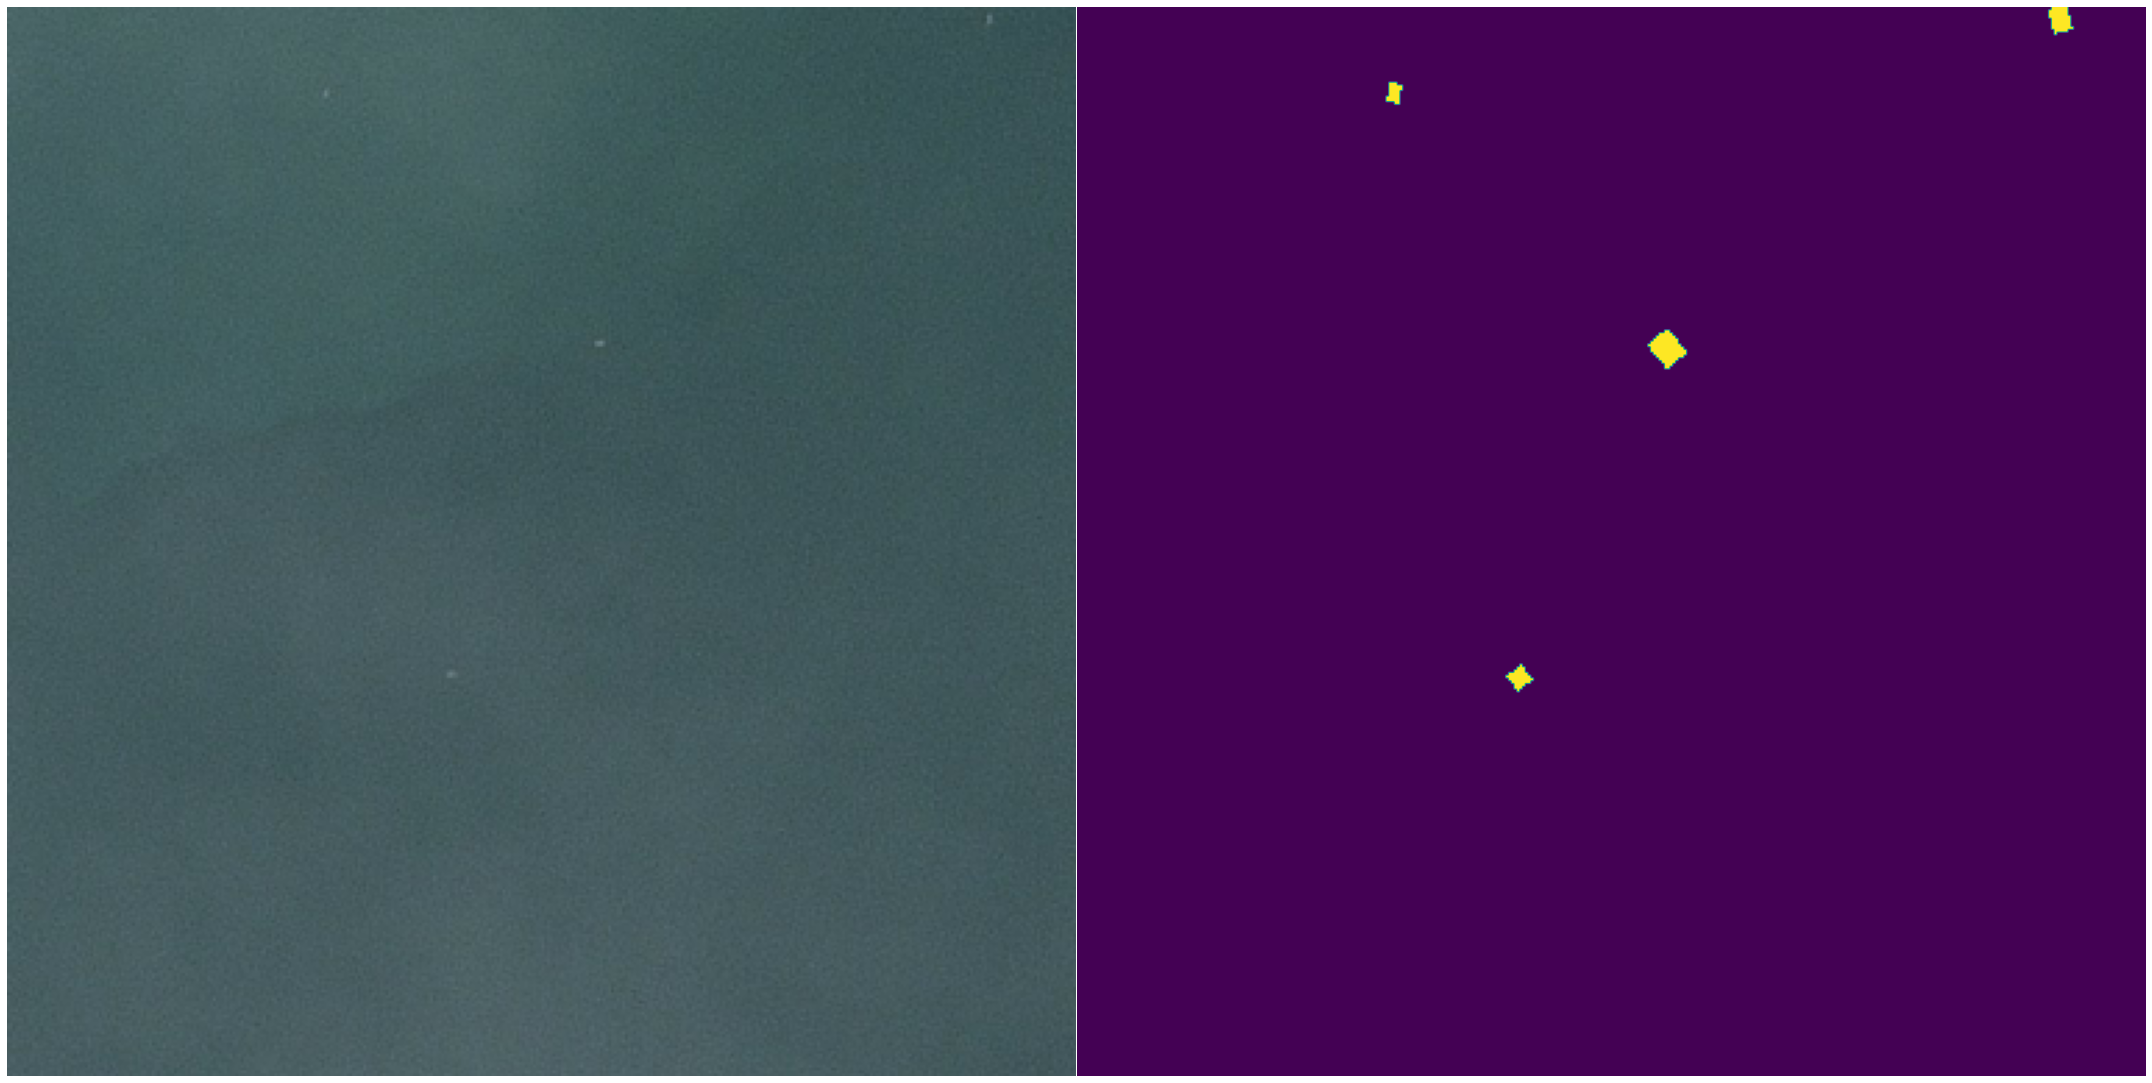

Done.


In [116]:
#masks_copy = masks.copy()
#new_masks = augment_imgs(masks_copy)

# Create Statistics

In [ ]:
id_list = list(set(masks.loc[masks['EncodedPixels'].apply(
    lambda x: isinstance(x, str)
    )]['ImageId'].tolist()))

bbox_sizes = []
for ImageId in id_list:
    img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()
    for rle in img_masks:
        bbox_size = get_box_size(rle)
        bbox_sizes.append(bbox_size)
    
plt.hist()